# Example of deep NN for MNIST data

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt 
import idx2numpy
import time

C:\Users\soren.b.daugaard\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup logging and help function

In [2]:
log_path = "./tensorboard_logs_nn_deep_mnist/05_batch_100_FC_1024/"

def variable_summaries(var):
    # Attach a lot of summaries to a Tensor (for TensorBoard visualization).
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

# Import dataset and convert to one-hot encoding and a [m,784] matrix

In [3]:
Y_test_classes = idx2numpy.convert_from_file('data/t10k-labels.idx1-ubyte')
X_test = idx2numpy.convert_from_file('data/t10k-images.idx3-ubyte')

Y_train_classes = idx2numpy.convert_from_file('data/train-labels.idx1-ubyte')
X_train = idx2numpy.convert_from_file('data/train-images.idx3-ubyte')

Digit= 5 Digit Encoded= [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


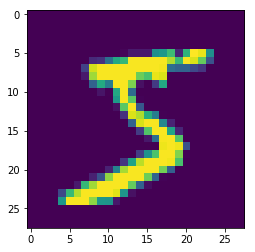

In [4]:
number_of_classes = np.unique(Y_test_classes).size

Y_test = np.eye(number_of_classes)[Y_test_classes]
Y_train = np.eye(number_of_classes)[Y_train_classes]

print("Digit=", Y_train_classes[0], "Digit Encoded=", Y_train[0])

plt.imshow(X_train[0])

In [5]:
# Convert input from image to 4D matrix
X_test = np.reshape(X_test,[-1,28,28,1])
X_train = np.reshape(X_train,[-1,28,28,1])

# Setup deep NN model
We'll be setting put a network with the following architecture:
CONV1 -> MAXPOOL1 -> CONV2 -> MAXPOOL2 -> FC RELU -> SOFTMAX

In [6]:
filters_conv1 = 32
filters_conv2 = 64
fc_size = 1024

with tf.name_scope("Input_Data"):
    X = tf.placeholder(tf.float32, [None,28,28,1], name="input")
    Y = tf.placeholder(tf.float32, [None,10], name="labels")

with tf.name_scope("CONV1_Layer"):
    # Define variables for model
    # CONV1 LAYER
    W1 = tf.Variable( tf.truncated_normal([5,5,1,filters_conv1], stddev=0.1) )
    b1 = tf.Variable(np.zeros(filters_conv1), dtype=tf.float32)

    variable_summaries(W1)
    variable_summaries(b1)
    
    CONV1 = tf.nn.relu( tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME") + b1)
    MAXPOOL1 = tf.nn.max_pool(CONV1, ksize=[1,2,2,1], strides=[1,2,2,1],padding="SAME")

with tf.name_scope("CONV2_Layer"):
    # CONV2 LAYER
    W2 = tf.Variable( tf.truncated_normal([5,5,filters_conv1,filters_conv2], stddev=0.1) )
    b2 = tf.Variable(np.zeros(filters_conv2), dtype=tf.float32)
    
    variable_summaries(W2)
    variable_summaries(b2)
    
    CONV2 = tf.nn.relu( tf.nn.conv2d(MAXPOOL1, W2,strides=[1,1,1,1],padding="SAME") + b2)
    MAXPOOL2 = tf.nn.max_pool(CONV2, ksize=[1,2,2,1], strides=[1,2,2,1],padding="SAME")

with tf.name_scope("FC1_Layer"):
    # FC LAYER
    W3 = tf.Variable( tf.truncated_normal([7*7*filters_conv2, fc_size], stddev=0.1 ))
    b3 = tf.Variable(np.zeros(fc_size), dtype=tf.float32)

    # Flatten image data
    FLATTEN = tf.reshape(MAXPOOL2, [-1,7*7*filters_conv2])

    # Fully-connected layer + dropout regularization
    FC = tf.nn.relu( tf.matmul(FLATTEN, W3) + b3 )
    keep_prob = tf.placeholder(tf.float32, name="Keep_Prob")
    FC = tf.nn.dropout(FC, keep_prob)

with tf.name_scope("Output_Layer"):
    # SOFTMAX layer
    W4 = tf.Variable(tf.truncated_normal([fc_size, 10], stddev=0.1))
    b4 = tf.Variable(np.zeros(10), dtype=tf.float32)

    # Note tf.nn.softmax is not called because the cost function expects unscalled logits
    ZOUT = tf.matmul(FC, W4) + b4
    prediction = tf.nn.softmax(ZOUT)
    

## Define cost and optimizer

In [7]:
# Cost function will use cross entropy
cost_fn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=ZOUT))

# Optimizer
#learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(0.0005).minimize(cost_fn) 
#GradientDescentOptimizer(learning_rate).minimize(cost_fn)


# Setup model to run predictions and calculate accuracy
# Evaluate predictions using tf.argmax to find call
with tf.name_scope("Accuracy"):
    correct_predictions = tf.equal(tf.argmax(Y,1), tf.argmax(prediction,1 ))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar("cost", cost_fn)

merged_summary = tf.summary.merge_all()

# Execute training of model

Iteration 0 processed at 216.15s Cost= 6.451606
Iteration 1 processed at 410.28s Cost= 2.7298064
Accuracy Test= 97.17%


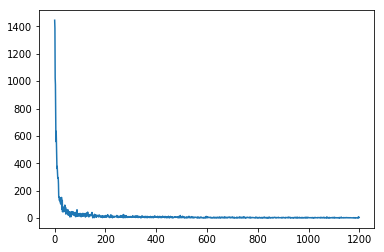

In [8]:
# global execution engine variable initializer 
init = tf.global_variables_initializer()

start_time = time.time()

with tf.Session() as sess:
    sess.run(init)
    
    # Write default graph to log
    tensor_board_writer = tf.summary.FileWriter(log_path, sess.graph)
    
    iterations = 2
    batch_size = 100
    costs = []
    
    log_for_every_i_b = 5
    
    batches_in_training_set = math.floor(X_train.shape[0] / batch_size)
    for i in range(iterations):
        for b in range(batches_in_training_set):
            i_b = (i*batches_in_training_set) + b
            # Would be better to randomize the batches but this is OK for now
            X_train_batch = X_train[(b*batch_size):((b+1)*batch_size),:]
            Y_train_batch = Y_train[(b*batch_size):((b+1)*batch_size),:]
            
            _, cost = sess.run([optimizer,cost_fn], feed_dict={X: X_train_batch, Y:Y_train_batch, keep_prob: 0.5})
            costs.append(cost)
            
            if(i_b % log_for_every_i_b == 0 and i_b != 0):
                _summary = sess.run(merged_summary, feed_dict={X: X_train_batch, Y:Y_train_batch, keep_prob: 1})
                tensor_board_writer.add_summary(_summary, i_b)
                #print("Batch",i_b,"processed at", "{:.2f}s".format(time.time()-start_time))
        
        print("Iteration",i,"processed at", "{:.2f}s".format(time.time()-start_time), "Cost=", cost)
            
    plt.plot(costs)
        
    print("Accuracy Test=", "{:.2f}%".format(100*sess.run(accuracy, {X: X_test, Y: Y_test, keep_prob: 1})))
    #print("Accuracy Train=", "{:.2f}%".format(100*sess.run(accuracy, {X: X_train, Y: Y_train, keep_prob: 1})))
    